# Understanding `get_probe_size` in 4D-STEM

Understanding py4DSTEM's get probe size implementation. Re-implemented in PyTorch.

## Problem

Find the center `(x0, y0)` and radius `r` of the central disk (probe) in a diffraction pattern.

```text
Diffraction pattern (DP)          Output
+------------------+              
|                  |              r  = 35 px
|     ████████     |      →       x0 = 128 px
|   ██████████████ |              y0 = 128 px
|     ████████     |              
|                  |              
+------------------+              
```

## Why is this a starting point?

Finding the probe center and radius is one of the **first preprocessing steps** in 4D-STEM. Many downstream analyses depend on knowing where the probe is.

Verified in py4DSTEM source code:

| Downstream task | py4DSTEM usage |
|-----------------|----------------|
| **Probe kernels** | `get_probe_kernel_flat()` uses center to shift probe to array corners for cross-correlation |
| **Calibration** | `DataCube.get_probe_size()` stores `(r, x0, y0)` in `calibration.set_probe_param()` |
| **Ptychography** | `DirectPtychography` centers vacuum probe using `get_CoM()` before reconstruction |
| **Disk detection** | `get_probe_kernel_edge_gaussian()` shifts probe to origin for template matching |

```text
Workflow:
                                    ┌─► Probe kernel → disk detection
                                    │
Raw 4D-STEM data ─► get_probe_size ─┼─► Calibration storage
                                    │
                                    └─► Ptychography initialization
```

## Solution strategy

The central disk is much brighter than the background. We exploit this by:

1. **Sweep thresholds**: Try many intensity cutoffs from low to high
2. **At each threshold**: Count pixels above that intensity and compute an equivalent circular radius
3. **Find the stable region**: The radius stays nearly constant over a wide range of thresholds (because the disk is so much brighter)
4. **Use the stable radius**: Average the radii in this flat region

```text
        Intensity
           ▲
      1.0  │      ████  ← Central disk (bright)
           │    ████████
           │  ████████████
      0.5  │████████████████
           │  background noise
      0.0  └──────────────────► Position

If threshold = 0.5 × max, only the bright disk passes
If threshold = 0.1 × max, disk + some noise passes  
If threshold = 0.9 × max, only the very brightest center passes
```

**Why does this work?** Over a range of thresholds (say 0.2 to 0.8), you capture roughly the same pixels (the disk), so the computed radius is stable. Outside this range, you either include noise (low threshold) or cut into the disk (high threshold).

In [1]:
import torch
import matplotlib.pyplot as plt

def get_device():
    """Get the best available device: CUDA -> XPU -> MPS -> CPU."""
    if torch.cuda.is_available():
        return torch.device('cuda')
    if hasattr(torch, 'xpu') and torch.xpu.is_available():
        return torch.device('xpu')
    if torch.backends.mps.is_available():
        return torch.device('mps')
    return torch.device('cpu')

device = get_device()
print(f"Using device: {device}")

Using device: cuda


## Setup: create synthetic diffraction pattern

diffraction_pattern shape: torch.Size([256, 256])
Intensity range: 62 to 10313 counts


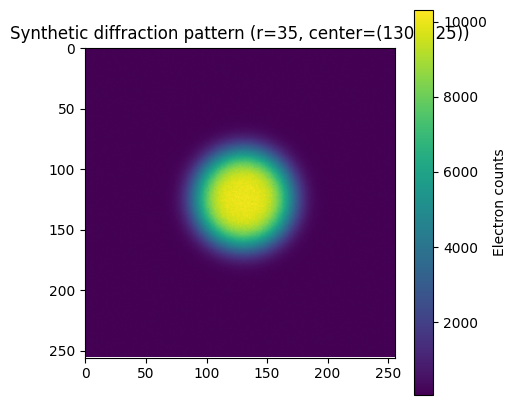

In [2]:
def create_synthetic_diffraction_pattern(
    size=256, disk_radius=30, disk_center=(128, 128), 
    max_counts=10000, background_counts=100, device='cpu'
):
    """
    Create a synthetic diffraction pattern with realistic electron counts.
    
    Args:
        size: image size in pixels
        disk_radius: radius of bright central disk
        disk_center: (x, y) center position
        max_counts: peak electron counts at disk center (typical: 1000-50000)
        background_counts: average background counts (typical: 10-500)
    
    Returns:
        diffraction_pattern: (size, size) tensor of electron counts
    """
    y = torch.arange(size, device=device).view(-1, 1)
    x = torch.arange(size, device=device).view(1, -1)
    dist_from_center = torch.sqrt((x - disk_center[0])**2 + (y - disk_center[1])**2)
    
    # Disk profile: super-Gaussian (flat top with sharp edges)
    disk = torch.exp(-0.5 * (dist_from_center / disk_radius)**4)
    
    # Scale to realistic electron counts
    diffraction_pattern = background_counts + (max_counts - background_counts) * disk
    
    # Add Poisson-like noise (sqrt scaling with intensity)
    noise = torch.sqrt(diffraction_pattern) * torch.randn(size, size, device=device)
    diffraction_pattern = diffraction_pattern + noise
    diffraction_pattern = torch.clamp(diffraction_pattern, min=0)  # No negative counts
    
    return diffraction_pattern

# Configuration - realistic 4D-STEM values
SIZE = 256
DISK_RADIUS = 35
DISK_CENTER = (130, 125)
MAX_COUNTS = 10000       # Peak intensity in electron counts
BACKGROUND_COUNTS = 100  # Background level

diffraction_pattern = create_synthetic_diffraction_pattern(
    SIZE, DISK_RADIUS, DISK_CENTER, MAX_COUNTS, BACKGROUND_COUNTS, device
)  # (H, W)

print(f"diffraction_pattern shape: {diffraction_pattern.shape}")
print(f"Intensity range: {diffraction_pattern.min():.0f} to {diffraction_pattern.max():.0f} counts")

plt.figure(figsize=(5, 5))
plt.imshow(diffraction_pattern.cpu(), cmap='viridis')
plt.colorbar(label='Electron counts')
plt.title(f'Synthetic diffraction pattern (r={DISK_RADIUS}, center={DISK_CENTER})')
plt.show()

## Step 1: create N binary masks at different thresholds

**What is a threshold?** A threshold is a fraction (0 to 1) of the maximum intensity. If `threshold = 0.3`, we keep pixels brighter than `0.3 × max_intensity`.

- `threshold = 0.01` means keep pixels above 1% of max (almost everything passes)
- `threshold = 0.99` means keep pixels above 99% of max (only the very brightest)

**Why N masks?** We don't know which single threshold perfectly captures the disk. By trying N=100 thresholds from 0.01 to 0.99, we can find the range where the computed radius is stable.

```text
Low threshold (0.01)         High threshold (0.99)
+------------------+         +------------------+
|██████████████████|         |                  |
|██████████████████|         |       ██         |
|██████████████████|   →     |      ████        |
|██████████████████|         |       ██         |
|██████████████████|         |                  |
+------------------+         +------------------+
  Captures everything          Only brightest core
  (disk + noise)
```

**Vectorized**: Instead of looping N times, we broadcast to create all masks at once.

diffraction_pattern shape: torch.Size([256, 256])
threshold_values shape: torch.Size([100])
binary_masks shape: torch.Size([100, 256, 256])


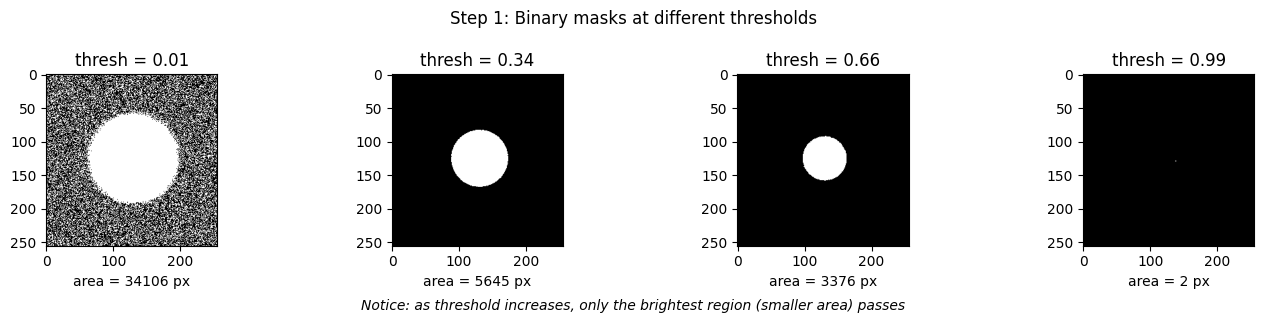

In [3]:
# Step 1: Create all N masks at once using broadcasting
N_THRESHOLDS = 100
THRESH_LOWER = 0.01
THRESH_UPPER = 0.99

max_intensity = diffraction_pattern.max()  # scalar
threshold_values = torch.linspace(THRESH_LOWER, THRESH_UPPER, N_THRESHOLDS, device=device)  # (N,)

# Broadcasting: diffraction_pattern is (H, W), threshold_values.view(N, 1, 1) is (N, 1, 1)
# Result: binary_masks is (N, H, W)
binary_masks = diffraction_pattern.unsqueeze(0) > (max_intensity * threshold_values.view(N_THRESHOLDS, 1, 1))

print(f"diffraction_pattern shape: {diffraction_pattern.shape}")
print(f"threshold_values shape: {threshold_values.shape}")
print(f"binary_masks shape: {binary_masks.shape}")

# Visualize 4 masks at different thresholds
fig, axes = plt.subplots(1, 4, figsize=(14, 3))
indices = [0, 33, 66, 99]
for ax, idx in zip(axes, indices):
    ax.imshow(binary_masks[idx].cpu(), cmap='gray')
    ax.set_title(f'thresh = {threshold_values[idx]:.2f}')
    ax.set_xlabel(f'area = {binary_masks[idx].sum().item()} px')
plt.suptitle('Step 1: Binary masks at different thresholds')
fig.text(0.5, -0.02, 'Notice: as threshold increases, only the brightest region (smaller area) passes', 
         ha='center', fontsize=10, style='italic')
plt.tight_layout()
plt.show()

## Step 2: calculate radius for each mask

For a circular disk, area $A = \pi r^2$, so $r = \sqrt{A / \pi}$.

We sum each mask to get the area, then compute the equivalent circular radius.

mask_areas shape: torch.Size([100])
radius_values shape: torch.Size([100])
radius_values range: 0.8 to 104.2 pixels


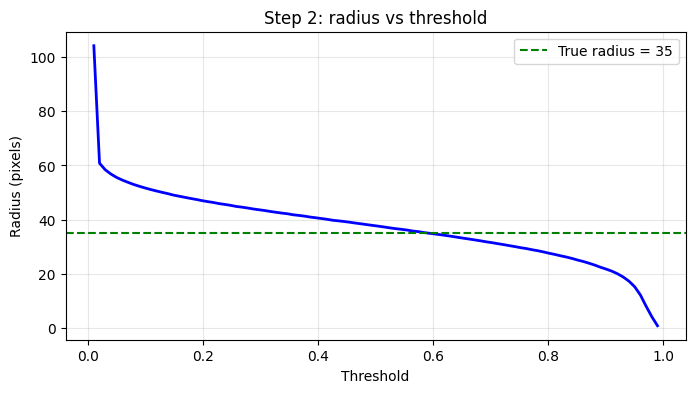

In [4]:
# Step 2: Calculate radius from area for each mask
# Sum over (H, W) dimensions to get area for each threshold
mask_areas = binary_masks.sum(dim=(1, 2)).float()  # (N,)
radius_values = torch.sqrt(mask_areas / torch.pi)  # (N,)

print(f"mask_areas shape: {mask_areas.shape}")
print(f"radius_values shape: {radius_values.shape}")
print(f"radius_values range: {radius_values.min():.1f} to {radius_values.max():.1f} pixels")

# Plot r vs threshold
plt.figure(figsize=(8, 4))
plt.plot(threshold_values.cpu(), radius_values.cpu(), 'b-', linewidth=2)
plt.axhline(DISK_RADIUS, color='g', linestyle='--', label=f'True radius = {DISK_RADIUS}')
plt.xlabel('Threshold')
plt.ylabel('Radius (pixels)')
plt.title('Step 2: radius vs threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Step 3: find the stable region

We compute the derivative $\frac{dr}{d(\text{thresh})}$ to find where radius is stable:

```text
r (radius)                        derivative dr/dθ
    │                                 │
140 │█                              0 │          ████████████████  ← Stable
    │ ██         ← Steep          -5 │         █                █
100 │   ███                           │        █                  █
    │      ████████████████  ← Flat   │       █                    
 40 │                      ████      │█████                        ← Steep
  0 └──────────────────────► thresh  └──────────────────────────► thresh
```

**Computing the derivative** using slicing:
```text
r_vals[1:] - r_vals[:-1] = [r1-r0, r2-r1, r3-r2, ..., r99-r98]
```

**Selection criteria**:
- `dr/dθ <= 0`: radius decreases or stays flat as threshold increases
- `dr/dθ >= 2 × median`: not too steep

### Why 2 × median?

A fixed cutoff like -5 doesn't work for all data. The median adapts to the scale:

```text
derivatives = [-50, -40, -2, -1, -0.5, -0.3, -0.2, -0.1]
                ↑↑ steep ↑↑        ↑↑↑↑ flat ↑↑↑↑

median = -1.25
2 × median = -2.5  ← Adaptive cutoff

Keeps: [-2, -1, -0.5, -0.3, -0.2, -0.1]
Rejects: [-50, -40]
```

**Boolean indexing** filters the stable radii:
```text
dr_dtheta   = [-40, -35, -2, -1, -0.5, -0.3, -0.2, -0.1, -5, -30]
stable_mask = [False, False, True, True, True, True, True, True, False, False]

r_vals[stable_mask].mean()      → Final radius
thresh_vals[stable_mask].mean() → Final threshold (for Step 4 CoM)
```

=== Stable Region Computation ===
1. Compute derivative: dr/dθ ranges from -43.38 to -0.22
2. Find median: -0.365
3. Adaptive cutoff: 2 × median = 2 × -0.365 = -0.729
4. Condition 1 (dr/dθ <= 0): 100 points pass
5. Condition 2 (dr/dθ >= -0.73): 82 points pass
6. Both conditions: 82 points in stable region

=== Results ===
final_radius = 37.79 px (true = 35)
final_threshold = 0.490


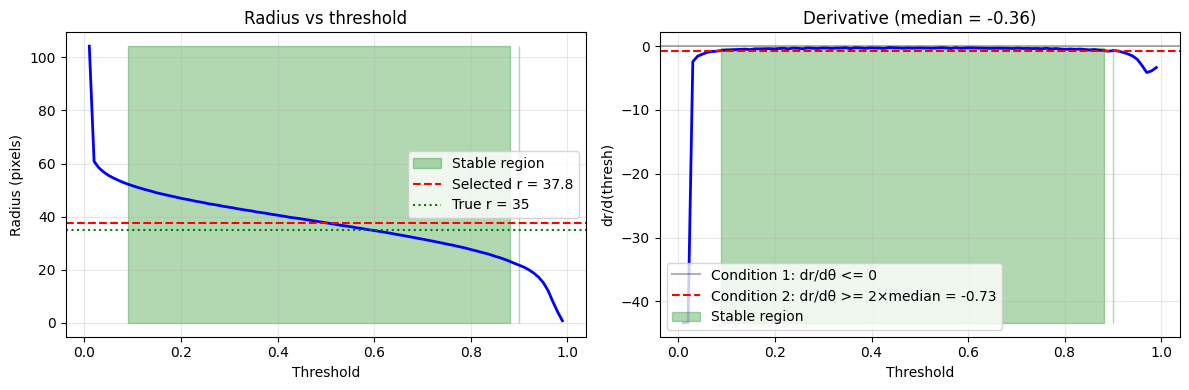

In [5]:
# Step 3: Find stable region using derivative
radius_derivative = torch.zeros_like(radius_values)  # (N,)
radius_derivative[1:] = radius_values[1:] - radius_values[:-1]
radius_derivative[0] = radius_derivative[1]

# Compute adaptive cutoff
median_derivative = radius_derivative.median()  # scalar
derivative_cutoff = 2 * median_derivative       # scalar

# Selection criteria
is_decreasing = radius_derivative <= 0              # (N,) bool
is_not_too_steep = radius_derivative >= derivative_cutoff  # (N,) bool
stable_region_mask = is_decreasing & is_not_too_steep      # (N,) bool

# Final values from stable region
final_radius = radius_values[stable_region_mask].mean().item()  # Python float
final_threshold = threshold_values[stable_region_mask].mean().item()  # Python float

# Show how the stable region was computed
print("=== Stable Region Computation ===")
print(f"1. Compute derivative: dr/dθ ranges from {radius_derivative.min():.2f} to {radius_derivative.max():.2f}")
print(f"2. Find median: {median_derivative:.3f}")
print(f"3. Adaptive cutoff: 2 × median = 2 × {median_derivative:.3f} = {derivative_cutoff:.3f}")
print(f"4. Condition 1 (dr/dθ <= 0): {is_decreasing.sum().item()} points pass")
print(f"5. Condition 2 (dr/dθ >= {derivative_cutoff:.2f}): {is_not_too_steep.sum().item()} points pass")
print(f"6. Both conditions: {stable_region_mask.sum().item()} points in stable region")
print(f"\n=== Results ===")
print(f"final_radius = {final_radius:.2f} px (true = {DISK_RADIUS})")
print(f"final_threshold = {final_threshold:.3f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: r vs threshold with stable region
ax1 = axes[0]
ax1.plot(threshold_values.cpu(), radius_values.cpu(), 'b-', linewidth=2)
ax1.fill_between(threshold_values.cpu().numpy(), 0, radius_values.max().item(), 
                  where=stable_region_mask.cpu().numpy(), alpha=0.3, color='green', label='Stable region')
ax1.axhline(final_radius, color='r', linestyle='--', label=f'Selected r = {final_radius:.1f}')
ax1.axhline(DISK_RADIUS, color='g', linestyle=':', label=f'True r = {DISK_RADIUS}')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Radius (pixels)')
ax1.set_title('Radius vs threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: derivative with cutoff explanation
ax2 = axes[1]
ax2.plot(threshold_values.cpu(), radius_derivative.cpu(), 'b-', linewidth=2)
ax2.axhline(0, color='k', linestyle='-', alpha=0.3, label='Condition 1: dr/dθ <= 0')
ax2.axhline(derivative_cutoff.item(), color='r', linestyle='--', 
            label=f'Condition 2: dr/dθ >= 2×median = {derivative_cutoff:.2f}')
ax2.fill_between(threshold_values.cpu().numpy(), radius_derivative.min().item(), radius_derivative.max().item(),
                  where=stable_region_mask.cpu().numpy(), alpha=0.3, color='green', label='Stable region')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('dr/d(thresh)')
ax2.set_title(f'Derivative (median = {median_derivative:.2f})')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 4: find the center using Center of Mass (CoM)

Using the threshold from the stable region, we create a binary mask and compute the weighted center of mass.

Selected threshold: 0.490
Found center: (125.04, 130.00)
True center: (130, 125)


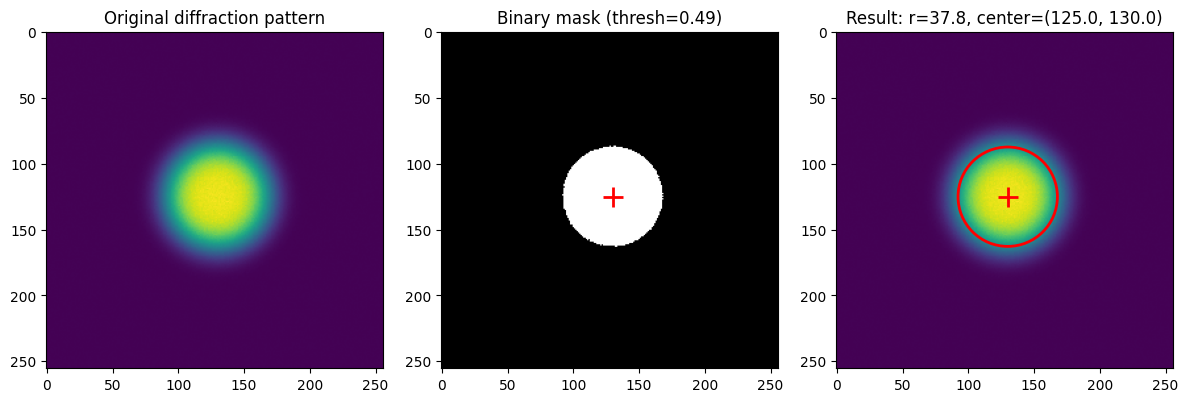

In [6]:
# Step 4: Find center using Center of Mass
# Use threshold from stable region (already computed as final_threshold)
probe_mask = diffraction_pattern > max_intensity * final_threshold  # (H, W) bool

# Create coordinate grids
H, W = diffraction_pattern.shape
# (-1) in view means "infer this dimension from the total size"
row_coords = torch.arange(H, device=device, dtype=diffraction_pattern.dtype).view(-1, 1)  # (H, 1)
col_coords = torch.arange(W, device=device, dtype=diffraction_pattern.dtype).view(1, -1)  # (1, W)

# Weighted sum for center of mass
# PyTorch doesn't allow multiplying a float tensor by a boolean tensor directly:
weighted_intensity = diffraction_pattern * probe_mask.float()  # (H, W)
total_intensity = weighted_intensity.sum()  # scalar
center_row = (row_coords * weighted_intensity).sum() / total_intensity  # scalar
center_col = (col_coords * weighted_intensity).sum() / total_intensity  # scalar

# Convert to Python floats for clarity
center_row = center_row.item()
center_col = center_col.item()

print(f"Selected threshold: {final_threshold:.3f}")
print(f"Found center: ({center_row:.2f}, {center_col:.2f})")
print(f"True center: {DISK_CENTER}")

# Visualize result
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(diffraction_pattern.cpu(), cmap='viridis')
axes[0].set_title('Original diffraction pattern')
axes[1].imshow(probe_mask.cpu(), cmap='gray')
axes[1].plot(center_col, center_row, 'r+', markersize=15, markeredgewidth=2)
axes[1].set_title(f'Binary mask (thresh={final_threshold:.2f})')
axes[2].imshow(diffraction_pattern.cpu(), cmap='viridis')
circle = plt.Circle((center_col, center_row), final_radius, fill=False, color='red', linewidth=2)
axes[2].add_patch(circle)
axes[2].plot(center_col, center_row, 'r+', markersize=15, markeredgewidth=2)
axes[2].set_title(f'Result: r={final_radius:.1f}, center=({center_row:.1f}, {center_col:.1f})')
plt.tight_layout()
plt.show()

## Complete function

All steps combined into a reusable function:

In [7]:
def compute_center_of_mass(intensity_array: torch.Tensor) -> tuple[float, float]:
    """
    Compute the center of mass of a 2D intensity array.
    
    Args:
        intensity_array: (H, W) tensor of intensity values
    
    Returns:
        (row_center, col_center): center of mass coordinates as Python floats
    """
    H, W = intensity_array.shape
    row_coords = torch.arange(H, device=intensity_array.device, dtype=intensity_array.dtype).view(-1, 1)
    col_coords = torch.arange(W, device=intensity_array.device, dtype=intensity_array.dtype).view(1, -1)
    total_intensity = intensity_array.sum()
    row_center = (row_coords * intensity_array).sum() / total_intensity
    col_center = (col_coords * intensity_array).sum() / total_intensity
    return row_center.item(), col_center.item()


def get_probe_size(
    diffraction_pattern: torch.Tensor, 
    thresh_lower: float = 0.01, 
    thresh_upper: float = 0.99, 
    n_thresholds: int = 100
) -> tuple[float, float, float]:
    """
    Get the center and radius of the probe in a diffraction pattern.
    Fully vectorized using PyTorch broadcasting.
    
    Args:
        diffraction_pattern: (H, W) diffraction pattern tensor
        thresh_lower: lower threshold bound (0-1)
        thresh_upper: upper threshold bound (0-1)
        n_thresholds: number of threshold steps
    
    Returns:
        (radius, row_center, col_center): probe radius and center coordinates
    """
    device = diffraction_pattern.device
    max_intensity = diffraction_pattern.max()
    
    # Step 1: Create all N masks at once
    threshold_values = torch.linspace(thresh_lower, thresh_upper, n_thresholds, device=device)  # (N,)
    binary_masks = diffraction_pattern.unsqueeze(0) > (max_intensity * threshold_values.view(n_thresholds, 1, 1))  # (N, H, W)
    
    # Step 2: Compute radii from areas
    mask_areas = binary_masks.sum(dim=(1, 2)).float()  # (N,)
    radius_values = torch.sqrt(mask_areas / torch.pi)  # (N,)
    
    # Step 3: Find stable region
    radius_derivative = torch.zeros_like(radius_values)  # (N,)
    radius_derivative[1:] = radius_values[1:] - radius_values[:-1]
    radius_derivative[0] = radius_derivative[1]
    
    median_derivative = radius_derivative.median()
    stable_region_mask = (radius_derivative <= 0) & (radius_derivative >= 2 * median_derivative)  # (N,) bool
    
    radius = radius_values[stable_region_mask].mean().item()
    
    # Step 4: Find center
    threshold = threshold_values[stable_region_mask].mean()
    probe_mask = diffraction_pattern > max_intensity * threshold  # (H, W) bool
    row_center, col_center = compute_center_of_mass(diffraction_pattern * probe_mask.float())
    
    return radius, row_center, col_center


# Test the function
radius_test, row_test, col_test = get_probe_size(diffraction_pattern)
print(f"get_probe_size result: r={radius_test:.2f}, center=({row_test:.2f}, {col_test:.2f})")
print(f"True values: r={DISK_RADIUS}, center={DISK_CENTER}")

get_probe_size result: r=37.79, center=(125.04, 130.00)
True values: r=35, center=(130, 125)


## Comparison: success vs failure cases

Three scenarios to demonstrate when the algorithm works and when it fails:

| Case | Max counts | Background | Ratio | Expected |
|------|------------|------------|-------|----------|
| **Ptychography** | 10000 | 100 | 100× | Works well |
| **Low contrast (CBED)** | 500 | 200 | 2.5× | Fails: no stable region |
| **High noise** | 10000 | 100 | 100× | Fails: jagged masks |

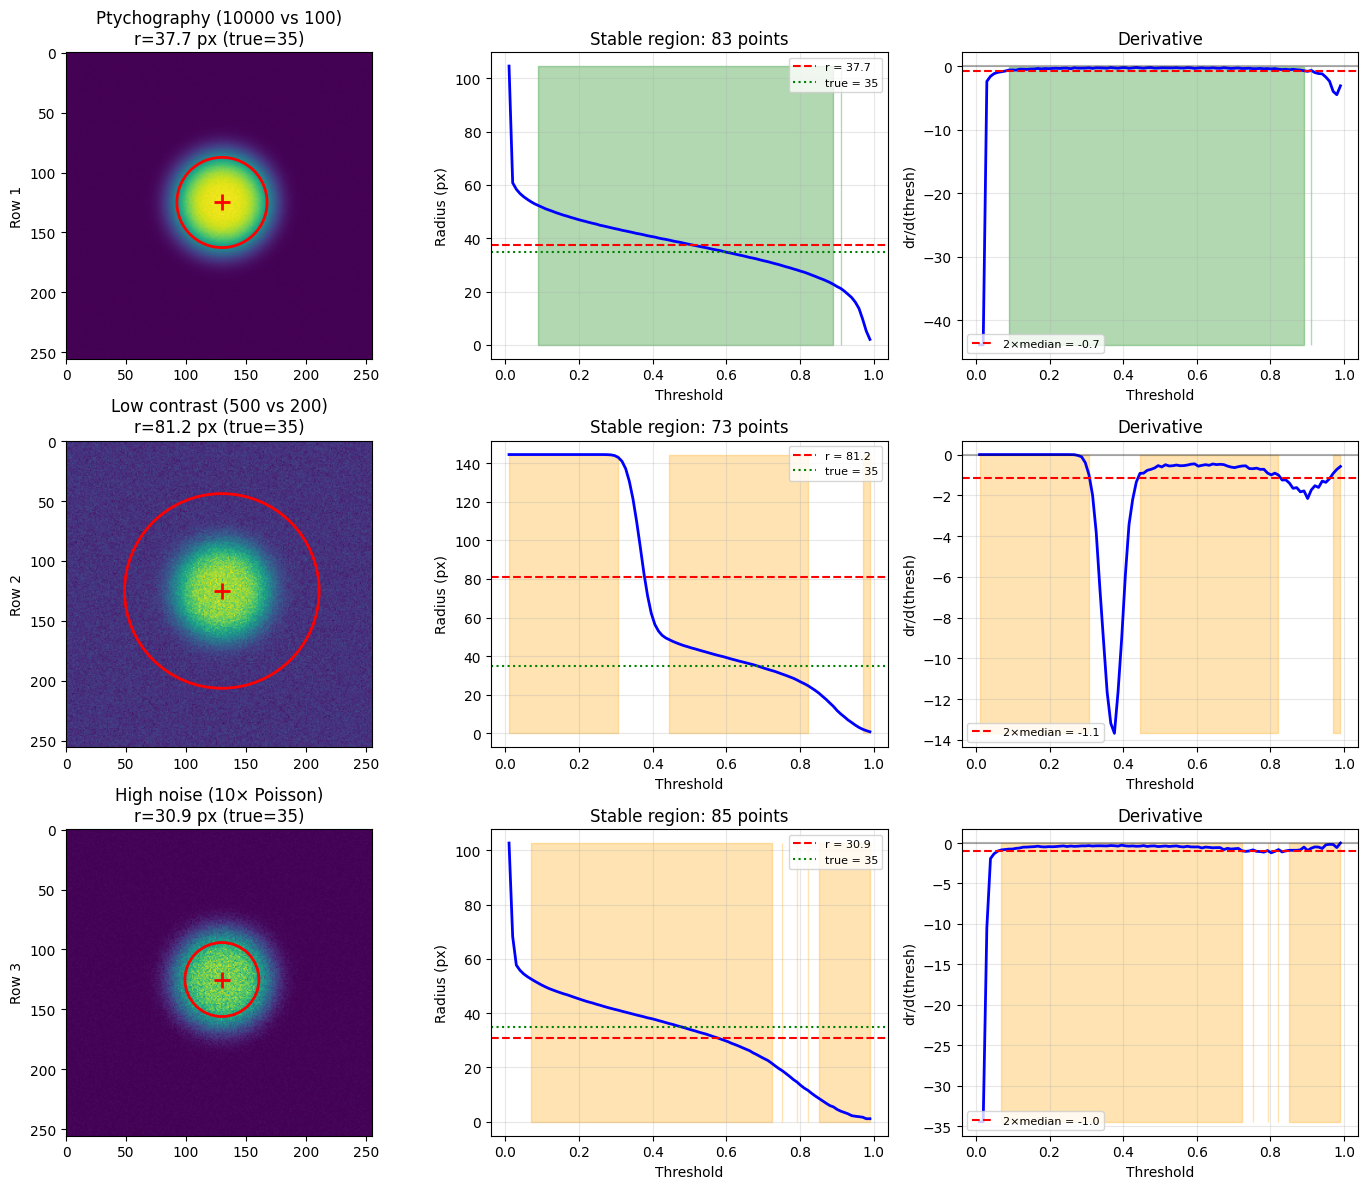

=== Results Summary ===
Case                      Radius          Center               Radius Error
------------------------------------------------------------------------
Ptychography               37.65 px      (125.02, 130.01)      2.65 px
Low contrast               81.24 px      (125.00, 129.90)     46.24 px
High noise                 30.90 px      (125.11, 129.96)      4.10 px

True values: r=35, center=(130, 125)


In [8]:
# Create all three test cases
def create_noisy_diffraction_pattern(size, disk_radius, disk_center, max_counts, background_counts, noise_multiplier, device):
    """Create a diffraction pattern with amplified noise."""
    y = torch.arange(size, device=device).view(-1, 1)
    x = torch.arange(size, device=device).view(1, -1)
    dist = torch.sqrt((x - disk_center[0])**2 + (y - disk_center[1])**2)
    disk = torch.exp(-0.5 * (dist / disk_radius)**4)
    dp = background_counts + (max_counts - background_counts) * disk
    noise = noise_multiplier * torch.sqrt(dp) * torch.randn(size, size, device=device)
    return torch.clamp(dp + noise, min=0)

# 1. Success: Ptychography (high contrast)
dp_ptycho = create_synthetic_diffraction_pattern(SIZE, DISK_RADIUS, DISK_CENTER, max_counts=10000, background_counts=100, device=device)
r_ptycho, row_ptycho, col_ptycho = get_probe_size(dp_ptycho)

# 2. Failure: Low contrast (CBED-like)
dp_low = create_synthetic_diffraction_pattern(SIZE, DISK_RADIUS, DISK_CENTER, max_counts=500, background_counts=200, device=device)
r_low, row_low, col_low = get_probe_size(dp_low)

# 3. Failure: High noise
dp_noisy = create_noisy_diffraction_pattern(SIZE, DISK_RADIUS, DISK_CENTER, max_counts=10000, background_counts=100, noise_multiplier=10, device=device)
r_noisy, row_noisy, col_noisy = get_probe_size(dp_noisy)

# Helper to compute stable region for visualization
def compute_stable_region(dp, n_thresh=100):
    thresh_vals = torch.linspace(0.01, 0.99, n_thresh, device=dp.device)
    max_int = dp.max()
    masks = dp.unsqueeze(0) > (max_int * thresh_vals.view(n_thresh, 1, 1))
    r_vals = torch.sqrt(masks.sum(dim=(1, 2)).float() / torch.pi)
    dr = torch.zeros_like(r_vals)
    dr[1:] = r_vals[1:] - r_vals[:-1]
    dr[0] = dr[1]
    stable = (dr <= 0) & (dr >= 2 * dr.median())
    return thresh_vals.cpu(), r_vals.cpu(), dr.cpu(), stable.cpu()

# Compute stable regions for all cases
thresh, r_ptycho_vals, dr_ptycho, stable_ptycho = compute_stable_region(dp_ptycho)
_, r_low_vals, dr_low, stable_low = compute_stable_region(dp_low)
_, r_noisy_vals, dr_noisy, stable_noisy = compute_stable_region(dp_noisy)

# Create combined 3×3 figure
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
cases = [
    ("Ptychography (10000 vs 100)", dp_ptycho, r_ptycho, row_ptycho, col_ptycho, r_ptycho_vals, dr_ptycho, stable_ptycho, 'green'),
    ("Low contrast (500 vs 200)", dp_low, r_low, row_low, col_low, r_low_vals, dr_low, stable_low, 'orange'),
    ("High noise (10× Poisson)", dp_noisy, r_noisy, row_noisy, col_noisy, r_noisy_vals, dr_noisy, stable_noisy, 'orange'),
]

for row_idx, (title, dp, r, row_c, col_c, r_vals, dr_vals, stable, color) in enumerate(cases):
    # Column 1: Diffraction pattern with detected circle
    ax = axes[row_idx, 0]
    ax.imshow(dp.cpu(), cmap='viridis')
    circle = plt.Circle((col_c, row_c), r, fill=False, color='red', linewidth=2)
    ax.add_patch(circle)
    ax.plot(col_c, row_c, 'r+', markersize=12, markeredgewidth=2)
    ax.set_title(f'{title}\nr={r:.1f} px (true={DISK_RADIUS})')
    ax.set_ylabel(f'Row {row_idx + 1}')
    
    # Column 2: Radius vs threshold
    ax = axes[row_idx, 1]
    ax.plot(thresh, r_vals, 'b-', linewidth=2)
    ax.fill_between(thresh.numpy(), 0, r_vals.max().item(), where=stable.numpy(), alpha=0.3, color=color)
    ax.axhline(r, color='r', linestyle='--', linewidth=1.5, label=f'r = {r:.1f}')
    ax.axhline(DISK_RADIUS, color='g', linestyle=':', linewidth=1.5, label=f'true = {DISK_RADIUS}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Radius (px)')
    ax.set_title(f'Stable region: {stable.sum().item()} points')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Column 3: Derivative
    ax = axes[row_idx, 2]
    ax.plot(thresh, dr_vals, 'b-', linewidth=2)
    ax.axhline(0, color='k', linestyle='-', alpha=0.3)
    cutoff = (2 * dr_vals.median()).item()
    ax.axhline(cutoff, color='r', linestyle='--', label=f'2×median = {cutoff:.1f}')
    ax.fill_between(thresh.numpy(), dr_vals.min().item(), dr_vals.max().item(), where=stable.numpy(), alpha=0.3, color=color)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('dr/d(thresh)')
    ax.set_title('Derivative')
    ax.legend(loc='lower left', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("=== Results Summary ===")
print(f"{'Case':<25} {'Radius':<15} {'Center':<20} {'Radius Error':<12}")
print("-" * 72)
print(f"{'Ptychography':<25} {r_ptycho:>6.2f} px      ({row_ptycho:>6.2f}, {col_ptycho:>6.2f})    {abs(r_ptycho - DISK_RADIUS):>6.2f} px")
print(f"{'Low contrast':<25} {r_low:>6.2f} px      ({row_low:>6.2f}, {col_low:>6.2f})    {abs(r_low - DISK_RADIUS):>6.2f} px")
print(f"{'High noise':<25} {r_noisy:>6.2f} px      ({row_noisy:>6.2f}, {col_noisy:>6.2f})    {abs(r_noisy - DISK_RADIUS):>6.2f} px")
print(f"\nTrue values: r={DISK_RADIUS}, center={DISK_CENTER}")

## Summary

| Step | Operation | Key idea |
|------|-----------|----------|
| 1 | Create N masks | Vectorized: `DP.unsqueeze(0) > thresh.view(N,1,1)` |
| 2 | Compute radii | $r = \sqrt{A / \pi}$ from mask areas |
| 3 | Find stable region | Where derivative $dr/d\theta \approx 0$ |
| 4 | Compute CoM | Weighted center of mass for (x0, y0) |

### Radius and center are found independently

The algorithm finds radius and center separately:

1. **Radius**: Found first by sweeping thresholds and looking for a stable region
2. **Center**: Found second using the threshold from step 3 to create a mask, then computing the center of mass

This means:
- A bad radius estimate does not directly affect the center estimate (and vice versa)
- The center uses the average threshold from the stable region, not the radius itself
- If the stable region is wrong, both values will be wrong (but for different reasons)

## When it works

- Central disk is significantly brighter than background
- Probe is roughly circular
- Position-averaged DP (reduces noise)

## When it fails

| Problem | Why |
|---------|-----|
| Low contrast | No clear stable region (background and disk overlap in intensity) |
| High noise | Jagged mask boundaries, noisy radius curve |
| Non-circular probe | Assumes $r = \sqrt{A/\pi}$ |
| Bragg peaks inside disk | Distorts CoM calculation |